Individual assignment
===
1. Preprocessing
2. Sanity checks
3. First-level analysis

# 0. Setup

## Imports

In [1]:
import jupyter_black

jupyter_black.load()

In [57]:
import os
from os.path import join as opj
import json
from nipype.interfaces.fsl import (
    BET,
    ExtractROI,
    FAST,
    FLIRT,
    ImageMaths,
    MCFLIRT,
    SliceTimer,
    Threshold,
    IsotropicSmooth,
    FLIRT,
    FNIRT,
    ApplyWarp,
)
from nipype.interfaces.fsl.utils import RobustFOV
import nibabel as nib
from nilearn import image, plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

# from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node
from IPython.display import Image

# Check if ENV variables are set
print(os.environ["FSLDIR"])
print(os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

# os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

/opt/fsl-5.0.11
NIFTI


## Download data and MNI atlas

In [3]:
# !gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
# !unzip ./ds000102.zip -d ./data

# add mni template to fsl dir
# os.makedirs(fslpath + "/data/standard", exist_ok=True)
# !wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O mniatlas.zip
# !unzip -oq mniatlas.zip -d ${FSLDIR}/data/standard

## Experiment parameters

In [4]:
project_root_dir = os.getcwd()
experiment_dir = project_root_dir + "/output"
output_dir = "datasink"
working_dir = "workingdir"
data_dir = project_root_dir + "/data/ds000102"

# list of subject identifiers
subject_list = ["02"]

# list of session identifiers
task_list = ["flanker"]

# Smoothing widths to apply
fwhm = [4]  # [4, 8]

# TR of functional images
with open(data_dir + "/task-flanker_bold.json", "rt") as fp:
    task_info = json.load(fp)
TR = task_info["RepetitionTime"]

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4


os.environ["FSLOUTPUTTYPE"] = "NIFTI"

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

### Inspect Data

In [5]:
anat = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/anat/sub-{subject_list[0]}_T1w.nii.gz"
)
func = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/func/sub-{subject_list[0]}_task-flanker_run-1_bold.nii.gz"
)

anat_data = anat.get_fdata()
func_data = func.get_fdata()[:, :, :, 4:]


# check the shape of the files
print("shape of anat file:", anat_data.shape)
print("shape of func file:", func_data.shape)

print(
    f"\nWe have {func_data.shape[2]} slices with a resolution of {func_data.shape[0]}x{func_data.shape[1]} voxels and {func_data.shape[3]} timepoints"
)

shape of anat file: (176, 256, 256)
shape of func file: (64, 64, 40, 142)

We have 40 slices with a resolution of 64x64 voxels and 142 timepoints


In [6]:
TA = TR - (TR / func_data.shape[2])

#### Plot of anatomical image

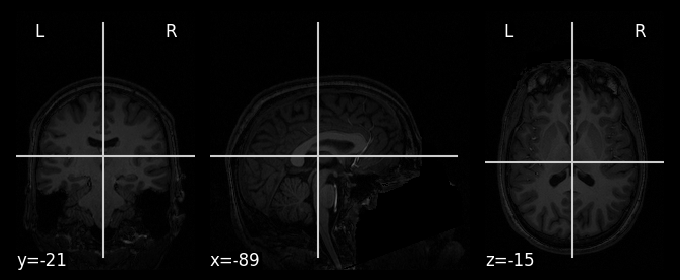

In [7]:
plotting.plot_anat(anat);

#### Plot of functional image

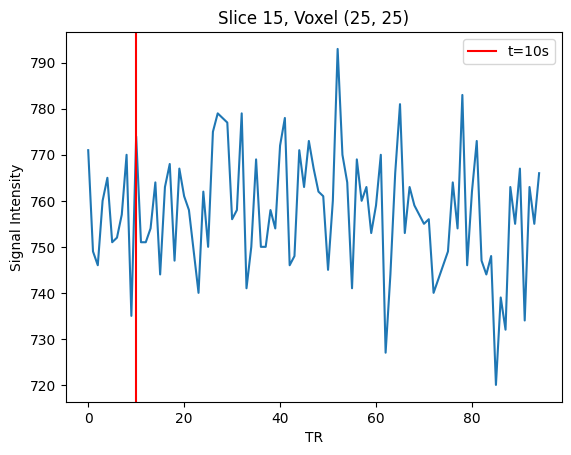

In [8]:
# define variables for number of slices, tr and ta

slice_no = 15
voxel_x = 25
voxel_y = 25

timepoints = slice(5, 100)
timepoint = 10

plt.plot(func_data[slice_no, voxel_x, voxel_y, timepoints])
plt.axvline(timepoint, color="red", label=f"t={timepoint}s")
plt.xlabel("TR")
plt.ylabel("Signal Intensity")
plt.title(f"Slice {slice_no}, Voxel {(voxel_x, voxel_y)}")
plt.legend();

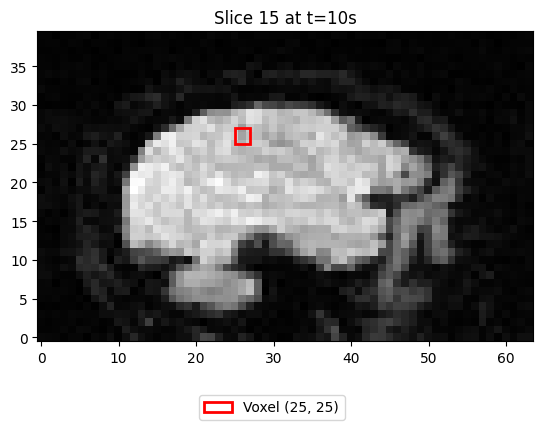

In [9]:
fig, ax = plt.subplots()
ax.imshow(func_data[slice_no, :, :, timepoint].T, cmap="gray", origin="lower")
rect = patches.Rectangle(
    (voxel_x, voxel_y),
    2,
    2,
    linewidth=2,
    edgecolor="r",
    facecolor="none",
    label=f"Voxel {(voxel_x, voxel_y)}",
)
ax.add_patch(rect)
ax.set_title(f"Slice {slice_no} at t={timepoint}s")
fig.legend(loc="lower center");

<div class="alert alert-info">everything looks alright</div>

# 1. Preprocessing

## Nodes for main workflow

In [10]:
# ExtractROI - remove first 4 volumes
# extract = Node(ExtractROI(t_min=4, t_size=-1, output_type="NIFTI"), name="extract")
extract = Node(
    ExtractROI(crop_list=[(0, -1), (0, -1), (0, -1), (4, -1)]), name="extract"
)  # alternative

# MCFLIRT - motion correction
mcflirt = Node(
    MCFLIRT(mean_vol=True, save_plots=True, output_type="NIFTI"), name="mcflirt"
)

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(
    SliceTimer(
        index_dir=False, interleaved=True, output_type="NIFTI", time_repetition=TR
    ),
    name="slicetimer",
)

# Smooth - image smoothing
smooth = Node(IsotropicSmooth(), name="smooth")
# smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(
    ArtifactDetect(
        norm_threshold=2,
        zintensity_threshold=3,
        mask_type="spm_global",
        parameter_source="FSL",
        use_differences=[True, False],
        plot_type="svg",
    ),
    name="art",
)

## Coregistration workflow

221204-17:46:47,402 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/workingdir/coregwf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/workingdir/coregwf/graph.png (graph2use=colored, simple_form=True).


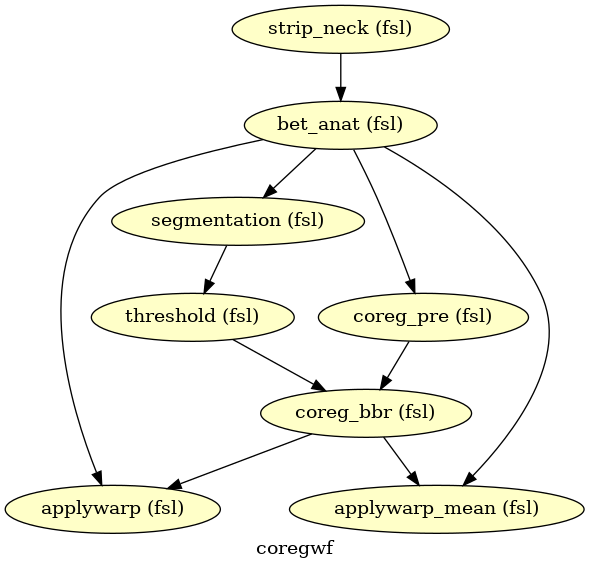

In [44]:
# RobustFOV - Remove neck from anatomical image to improve skullstripping
strip_neck = Node(RobustFOV(), name="strip_neck")

# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5, robust=True, output_type="NIFTI_GZ"), name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type="NIFTI_GZ"), name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]


# Threshold - Threshold WM probability image
threshold = Node(
    Threshold(thresh=0.5, args="-bin", output_type="NIFTI_GZ"), name="threshold"
)

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type="NIFTI_GZ"), name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(
    FLIRT(
        dof=6,
        cost="bbr",
        schedule=opj(os.getenv("FSLDIR"), "etc/flirtsch/bbr.sch"),
        output_type="NIFTI_GZ",
    ),
    name="coreg_bbr",
)

# Apply coregistration warp to functional images
applywarp = Node(
    FLIRT(interp="spline", apply_isoxfm=iso_size, output_type="NIFTI"), name="applywarp"
)

# Apply coregistration warp to mean file
applywarp_mean = Node(
    FLIRT(interp="spline", apply_isoxfm=iso_size, output_type="NIFTI_GZ"),
    name="applywarp_mean",
)

# Create a coregistration workflow
coregwf = Workflow(name="coregwf")
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect(
    [
        (strip_neck, bet_anat, [("out_roi", "in_file")]),
        (bet_anat, segmentation, [("out_file", "in_files")]),
        (segmentation, threshold, [(("partial_volume_files", get_wm), "in_file")]),
        (bet_anat, coreg_pre, [("out_file", "reference")]),
        (threshold, coreg_bbr, [("out_file", "wm_seg")]),
        (coreg_pre, coreg_bbr, [("out_matrix_file", "in_matrix_file")]),
        (coreg_bbr, applywarp, [("out_matrix_file", "in_matrix_file")]),
        (bet_anat, applywarp, [("out_file", "reference")]),
        (coreg_bbr, applywarp_mean, [("out_matrix_file", "in_matrix_file")]),
        (bet_anat, applywarp_mean, [("out_file", "reference")]),
    ]
)

coregwf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(coregwf.base_dir, "coregwf", "graph.png"))

## Normalization workflow

221204-18:35:32,960 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/workingdir/normwf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/workingdir/normwf/graph.png (graph2use=colored, simple_form=True).


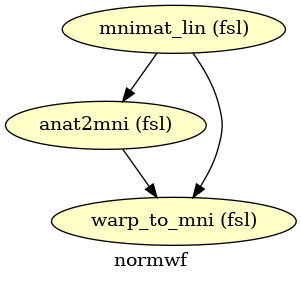

In [80]:
normwf = Workflow(name="normwf", base_dir=opj(experiment_dir, working_dir))

# linear transformation of t1 to mni template
mnimat_lin = Node(
    FLIRT(cost_func="normcorr", dof=12, reference=mni_template), name="mnimat_lin"
)

# non-linear transformation of t1 to mni (using params from linear transf.)
anat2mni = Node(FNIRT(ref_file=mni_template, warped_file="warped.nii"), name="anat2mni")

# warp epi data to mni template
warp_to_mni = Node(ApplyWarp(ref_file=mni_template), name="warp_to_mni")

normwf.connect(
    [
        (mnimat_lin, anat2mni, [("out_matrix_file", "affine_file")]),
        (anat2mni, warp_to_mni, [("field_file", "field_file")]),
        (mnimat_lin, warp_to_mni, [("out_matrix_file", "postmat")]),
    ]
)

normwf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(normwf.base_dir, "normwf", "graph.png"))

## IO stream

In [81]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(
    IdentityInterface(fields=["subject_id", "task_name"]), name="infosource"
)
infosource.iterables = [("subject_id", subject_list), ("task_name", task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj(
    "sub-{subject_id}",
    "anat",
    "sub-{subject_id}_T1w.nii.gz",
)
func_file = opj(
    "sub-{subject_id}",
    "func",
    "sub-{subject_id}_task-{task_name}_run-1_bold.nii.gz",
)

templates = {"anat": anat_file, "func": func_file}
selectfiles = Node(SelectFiles(templates, base_directory=data_dir), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(
    DataSink(base_directory=experiment_dir, container=output_dir), name="datasink"
)

## Use the following DataSink output substitutions
substitutions = [
    ("_subject_id_", "sub-"),
    ("_task_name_", "/task-"),
    ("_fwhm_", "fwhm-"),
    ("_roi", ""),
    ("_mcf", ""),
    ("_st", ""),
    ("_flirt", ""),
    (".nii_mean_reg", "_mean"),
    (".nii.par", ".par"),
]
subjFolders = [("fwhm-%s/" % f, "fwhm-%s_" % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Connect main workflow

In [83]:
# Create a preprocessing workflow
preproc = Workflow(name="preproc")
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect(
    [
        (
            infosource,
            selectfiles,
            [("subject_id", "subject_id"), ("task_name", "task_name")],
        ),
        (selectfiles, extract, [("func", "in_file")]),
        (extract, mcflirt, [("roi_file", "in_file")]),
        (mcflirt, slicetimer, [("out_file", "in_file")]),
        (
            selectfiles,
            coregwf,
            [("anat", "strip_neck.in_file"), ("anat", "coreg_bbr.reference")],
        ),
        (
            mcflirt,
            coregwf,
            [
                ("mean_img", "coreg_pre.in_file"),
                ("mean_img", "coreg_bbr.in_file"),
                ("mean_img", "applywarp_mean.in_file"),
            ],
        ),
        (slicetimer, coregwf, [("slice_time_corrected_file", "applywarp.in_file")]),
        (
            coregwf,
            normwf,
            [
                ("segmentation.restored_image", "mnimat_lin.in_file"),
                ("segmentation.restored_image", "anat2mni.in_file"),
                ("applywarp.out_file", "warp_to_mni.in_file"),
            ],
        ),
        (normwf, smooth, [("warp_to_mni.out_file", "in_file")]),
        (mcflirt, datasink, [("par_file", "preproc.@par")]),
        (smooth, datasink, [("out_file", "preproc.@smooth")]),
        (coregwf, datasink, [("applywarp_mean.out_file", "preproc.@mean")]),
        (coregwf, art, [("applywarp.out_file", "realigned_files")]),
        (mcflirt, art, [("par_file", "realignment_parameters")]),
        (
            coregwf,
            datasink,
            [
                ("coreg_bbr.out_matrix_file", "preproc.@mat_file"),
                ("bet_anat.out_file", "preproc.@brain"),
            ],
        ),
        (
            normwf,
            datasink,
            [
                ("warp_to_mni.out_file", "datasink.@warped_to_mni"),
                ("anat2mni.warped_file", "datasink.@_file"),
            ],
        ),
        (
            art,
            datasink,
            [
                ("outlier_files", "preproc.@outlier_files"),
                ("plot_files", "preproc.@plot_files"),
            ],
        ),
    ]
)

## Visualize the complete workflow

221204-18:35:54,42 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


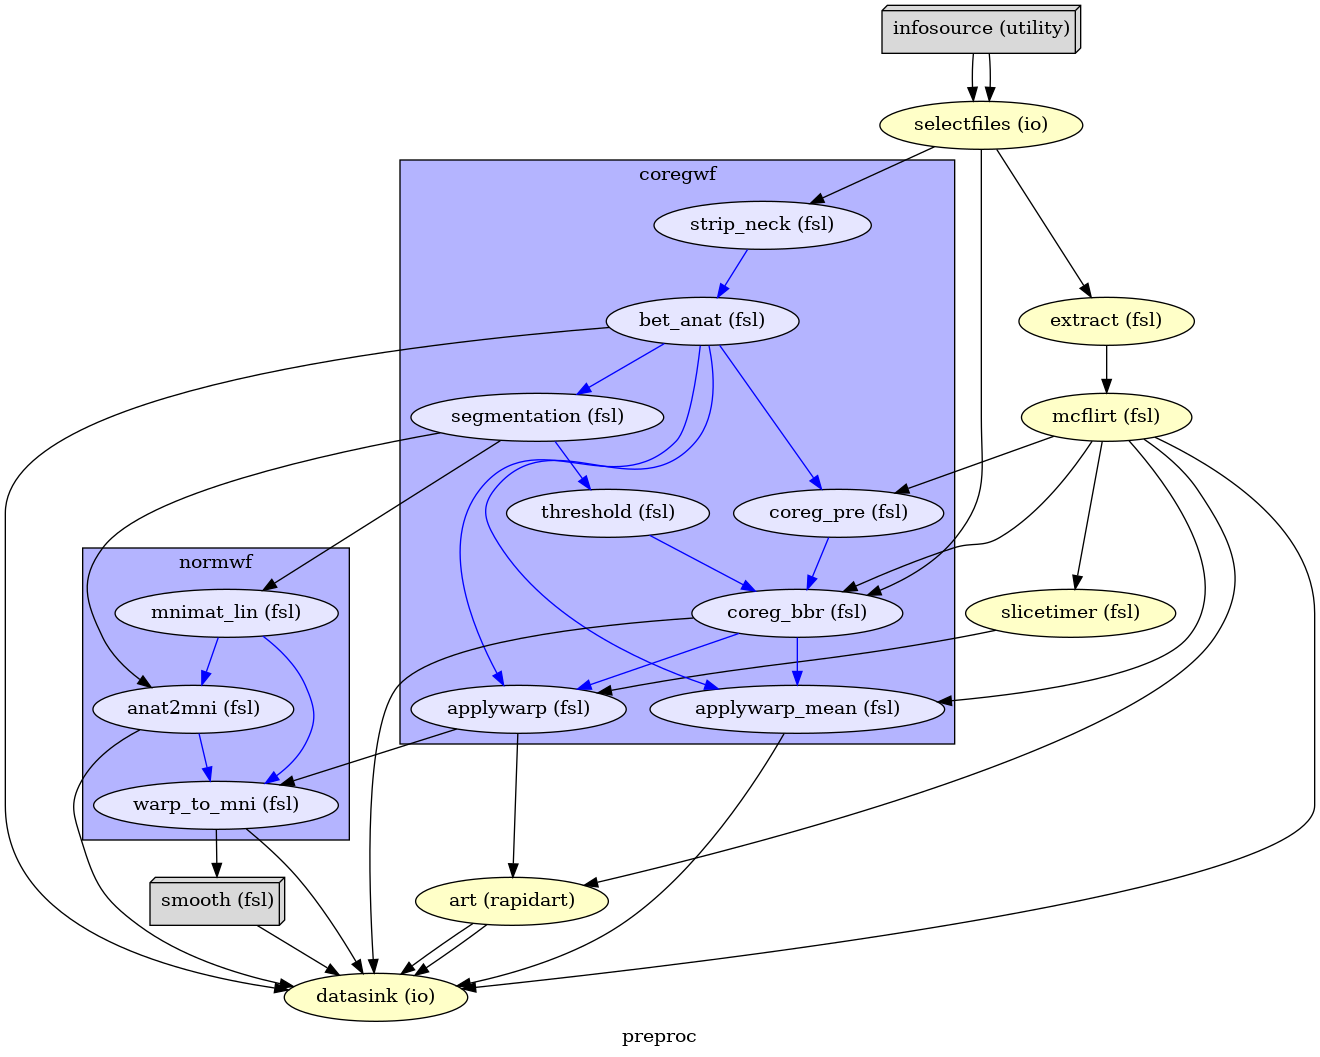

In [84]:
# Create preproc output graph
preproc.write_graph(graph2use="colored", format="png", simple_form=True)

Image(filename=opj(preproc.base_dir, "preproc", "graph.png"))

221204-18:35:55,613 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


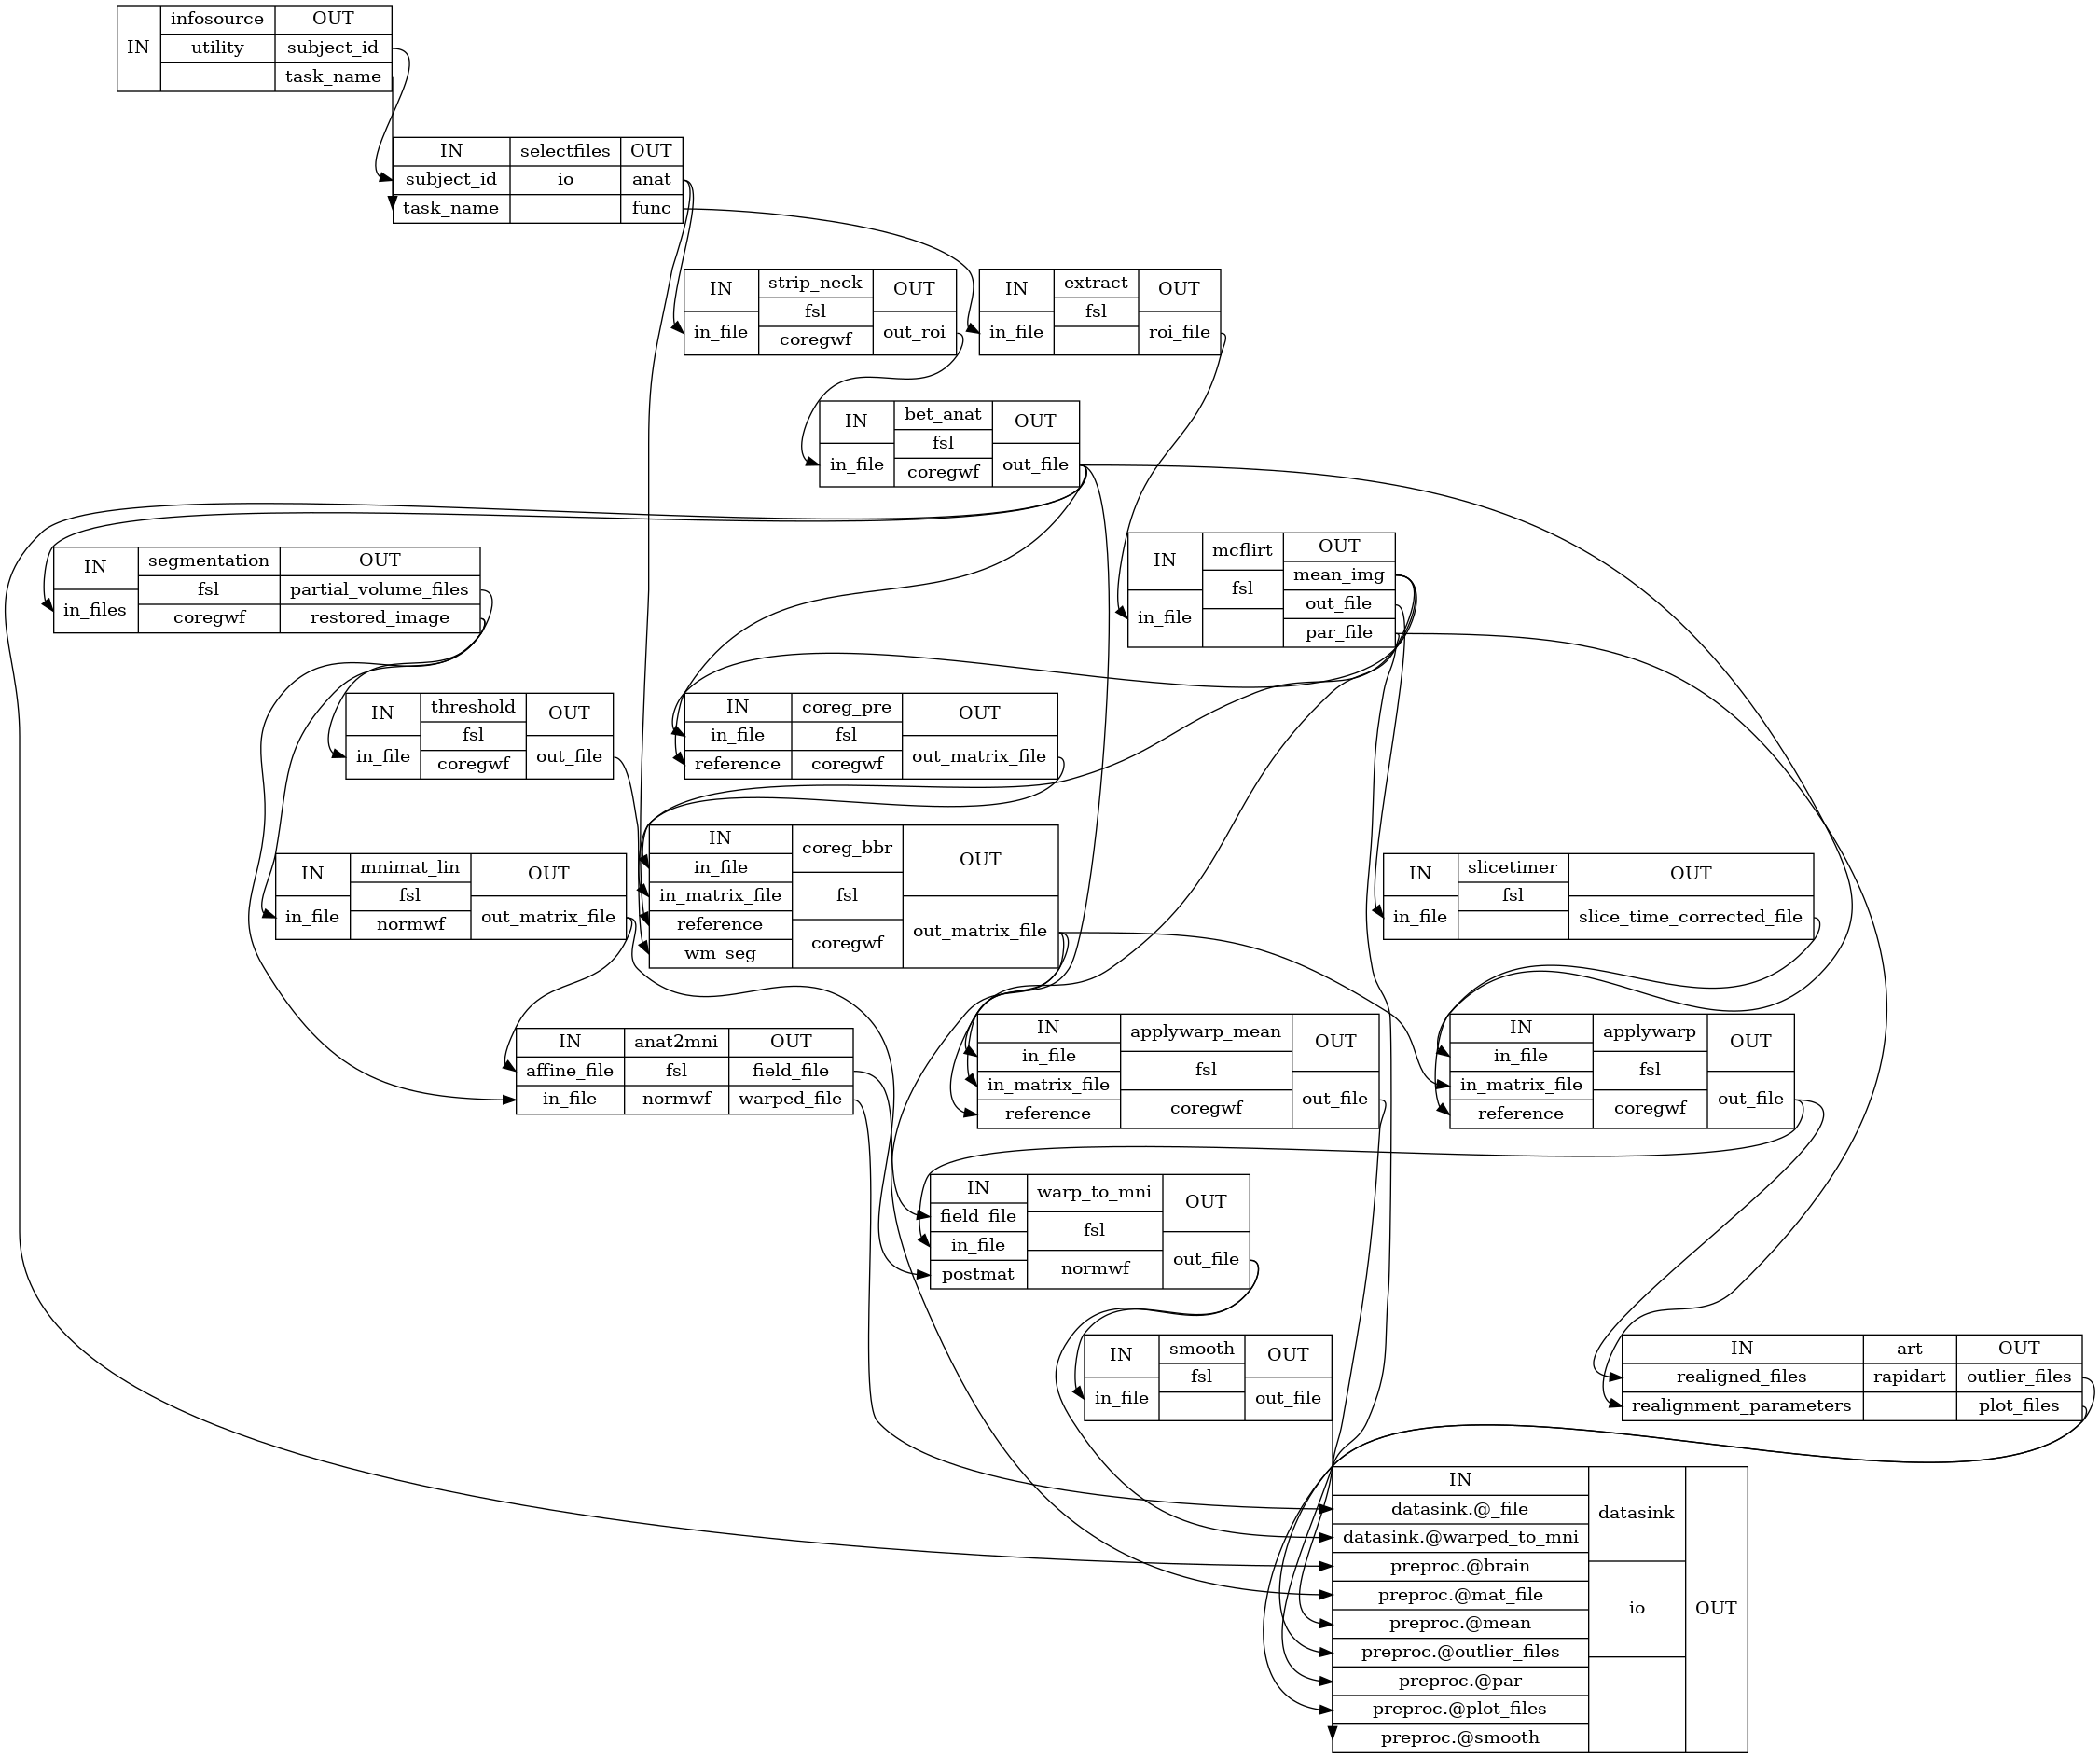

In [85]:
# Visualize the detailed graph
preproc.write_graph(graph2use="flat", format="png", simple_form=True)
Image(filename=opj(preproc.base_dir, "preproc", "graph_detailed.png"))

## Run workflow

In [ ]:
preproc.run("MultiProc", plugin_args={"n_procs": 8})

221204-18:36:15,928 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']


221204-18:36:15,954 nipype.workflow INFO:
	 Running in parallel.


INFO:nipype.workflow:Running in parallel.


221204-18:36:15,959 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-18:36:16,231 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/work/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "preproc.selectfiles" in "/work/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/selectfiles".


221204-18:36:16,242 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


221204-18:36:16,250 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001993s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.001993s.


221204-18:36:17,965 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).


INFO:nipype.workflow:[Job 0] Completed (preproc.selectfiles).


221204-18:36:17,983 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-18:36:18,218 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.strip_neck" in "/work/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/strip_neck".
221204-18:36:18,218 nipype.workflow INFO:
	 [Node] Setting-up "preproc.extract" in "/work/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/extract".


INFO:nipype.workflow:[Node] Setting-up "preproc.coregwf.strip_neck" in "/work/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/strip_neck".
INFO:nipype.workflow:[Node] Setting-up "preproc.extract" in "/work/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/extract".


221204-18:36:18,231 nipype.workflow INFO:
	 [Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


INFO:nipype.workflow:[Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


221204-18:36:18,234 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


INFO:nipype.workflow:[Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


221204-18:36:19,562 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 1.320369s.


INFO:nipype.workflow:[Node] Finished "extract", elapsed time 1.320369s.


221204-18:36:19,636 nipype.workflow INFO:
	 [Node] Finished "strip_neck", elapsed time 1.398893s.


INFO:nipype.workflow:[Node] Finished "strip_neck", elapsed time 1.398893s.


221204-18:36:19,964 nipype.workflow INFO:
	 [Job 1] Completed (preproc.extract).


INFO:nipype.workflow:[Job 1] Completed (preproc.extract).


221204-18:36:19,976 nipype.workflow INFO:
	 [Job 2] Completed (preproc.coregwf.strip_neck).


INFO:nipype.workflow:[Job 2] Completed (preproc.coregwf.strip_neck).


221204-18:36:19,989 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-18:36:20,154 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/work/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/mcflirt".
221204-18:36:20,155 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.bet_anat" in "/work/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/bet_anat".


INFO:nipype.workflow:[Node] Setting-up "preproc.mcflirt" in "/work/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/mcflirt".
INFO:nipype.workflow:[Node] Setting-up "preproc.coregwf.bet_anat" in "/work/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/bet_anat".


221204-18:36:20,181 nipype.workflow INFO:
	 [Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>
221204-18:36:20,181 nipype.workflow INFO:
	 [Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


INFO:nipype.workflow:[Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>
INFO:nipype.workflow:[Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


221204-18:36:21,962 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coregwf.bet_anat
                       * preproc.mcflirt


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coregwf.bet_anat
                       * preproc.mcflirt


221204-18:36:25,968 nipype.workflow INFO:
	 [Node] Finished "bet_anat", elapsed time 5.781269s.


INFO:nipype.workflow:[Node] Finished "bet_anat", elapsed time 5.781269s.


221204-18:36:27,967 nipype.workflow INFO:
	 [Job 4] Completed (preproc.coregwf.bet_anat).


INFO:nipype.workflow:[Job 4] Completed (preproc.coregwf.bet_anat).


221204-18:36:27,970 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.mcflirt


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.mcflirt


221204-18:36:28,95 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.segmentation" in "/work/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/segmentation".


INFO:nipype.workflow:[Node] Setting-up "preproc.coregwf.segmentation" in "/work/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/segmentation".


221204-18:36:28,107 nipype.workflow INFO:
	 [Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


INFO:nipype.workflow:[Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


221204-18:36:29,969 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coregwf.segmentation
                       * preproc.mcflirt


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coregwf.segmentation
                       * preproc.mcflirt


# 2. Sanity checks

## Inspect output

In [16]:
!tree output/datasink/preproc

output/datasink/preproc
└── sub-02
    └── task-flanker
        ├── art.sub-02_task-flanker_run-1_bold_outliers.txt
        ├── fwhm-4_sub-02_task-flanker_run-1_bold_smooth.nii
        ├── plot.sub-02_task-flanker_run-1_bold.svg
        ├── sub-02_T1w_brain.nii.gz
        ├── sub-02_task-flanker_run-1_bold.par
        ├── sub-02_task-flanker_run-1_bold_mean.mat
        └── sub-02_task-flanker_run-1_bold_mean.nii.gz

2 directories, 7 files


## Visualize results

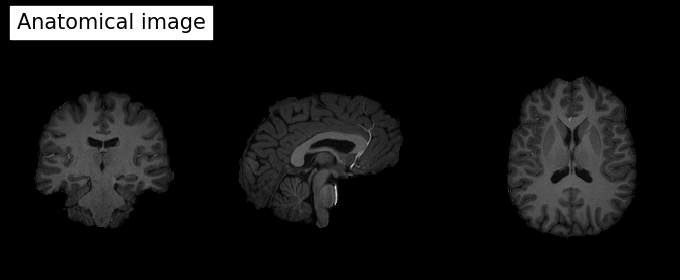

In [17]:
#%matplotlib inline
out_path = f"output/datasink/preproc/sub-{subject_list[0]}/task-flanker"

plotting.plot_epi(
    opj(out_path, f"sub-{subject_list[0]}_T1w_brain.nii.gz"),
    title="Anatomical image",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="gray",
);

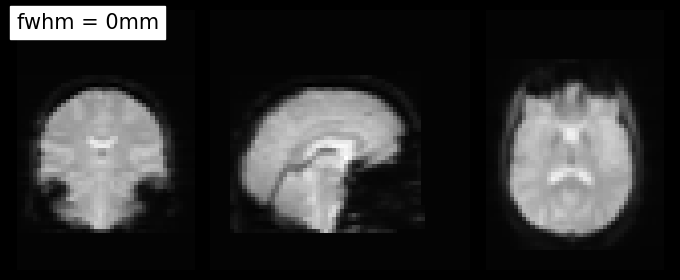

In [18]:
plotting.plot_epi(
    opj(out_path, f"sub-{subject_list[0]}_task-flanker_run-1_bold_mean.nii.gz"),
    title="fwhm = 0mm",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="gray",
);

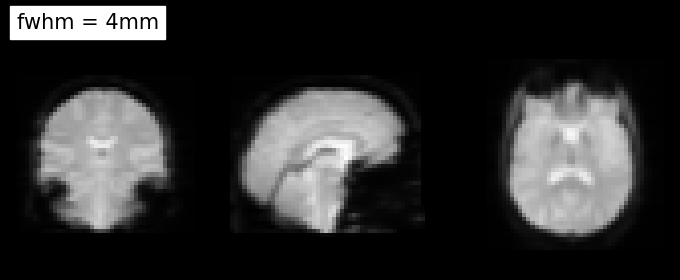

In [19]:
plotting.plot_epi(
    image.mean_img(
        opj(
            out_path, f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_smooth.nii"
        )
    ),
    title="fwhm = 4mm",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="gray",
);

## Check shape of preprocessed image

In [22]:
pp_anat = nib.load(opj(out_path, f"sub-{subject_list[0]}_T1w_brain.nii.gz")).get_fdata()

print(
    f"\nAnat: We have {pp_anat.shape[0]} slices with a resolution of {pp_anat.shape[1]}x{pp_anat.shape[2]} voxels"
)


Anat: We have 176 slices with a resolution of 256x256 voxels


In [23]:
pp_func = nib.load(
    opj(out_path, f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_smooth.nii")
).get_fdata()

print(
    f"\nFunc: We have {pp_func.shape[0]} slices with a resolution of {pp_func.shape[1]}x{pp_func.shape[2]} voxels and {pp_func.shape[3]} timepoints"
)


Func: We have 44 slices with a resolution of 64x64 voxels and 142 timepoints


<div class="alert alert-info">It looks good, the dimensions seem swapped compared to the input image (probably a normal procedure) and the first 4 slices were not removed (have to check again the extract node).</div>

## Motion

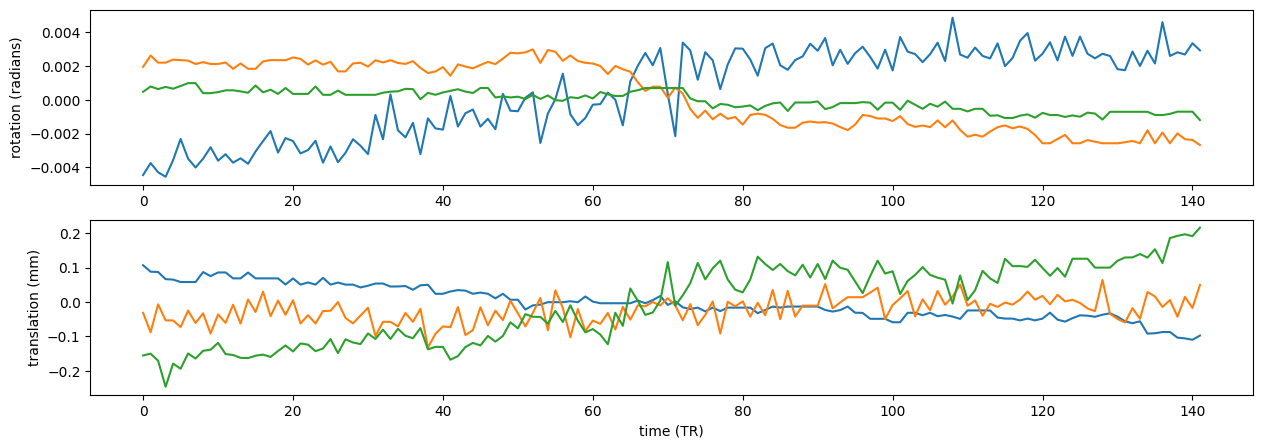

In [24]:
par = np.loadtxt(
    "output/datasink/preproc/sub-02/task-flanker/sub-02_task-flanker_run-1_bold.par"
)
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel("rotation (radians)")
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel("time (TR)")
axes[1].set_ylabel("translation (mm)");

<div class="alert alert-info">Seems to be an outlier at around volume 75 on the x-axis (rotation)</div>

Outliers were detected at volumes: [0. 1. 2. 3.]


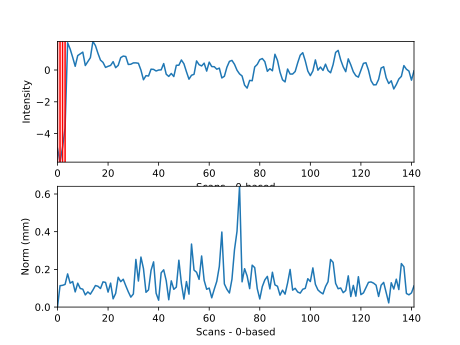

In [25]:
outlier_ids = np.loadtxt(
    "output/datasink/preproc/sub-02/task-flanker/art.sub-02_task-flanker_run-1_bold_outliers.txt"
)
print("Outliers were detected at volumes: %s" % outlier_ids)

from IPython.display import SVG

SVG(
    filename="output/datasink/preproc/sub-02/task-flanker/plot.sub-02_task-flanker_run-1_bold.svg"
)

## Check normalization

Visualize normalization results by overlaying raw and normalized files with MNI template mask

In [32]:
#
#
#

# 3. First Level Analysis

Using the preprocessed files, perform a first-level analysis. The steps are:

- Setup Model (using Nilearn's ```FirstLevelModel```)

- Fit the model to the data
  - use the events file stored in the data directory
  - use the motion parameter as confounds
  
  
- Plot the design matrix
- Define the contrasts
  - congruent_correct > baseline
  - incongruent_correct > baseline
  - incongruent-congruent
  - congruent-incongruent
  - motion parameters > baseline
- Calculate a z-statistics map for each contrast
- Plot the z-statistics maps (using the subject's warped anatomical image as background)

In [33]:
#
#
#